In [1]:
import stan
import nest_asyncio
nest_asyncio.apply()

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Question 1

## (a)

We have that

$$
y_i = f ( t_i ) + \epsilon_i,
$$

where $\epsilon_i \sim \text{Normal} (0, \sigma^2)$.

**Mean of $\pmb{y}$**

$$
\mathbb{E} (y_i) = \mathbb{E} \{ f(t_i) + \epsilon_i \}
= \mathbb{E} \{ f(t_i) \} + \mathbb{E} ( \epsilon_i )
= 0
$$

$$
\implies \mathbb{E} (\pmb{y}) = \pmb{0}
$$

**Covariance of $\pmb{y}$**

$$
\text{Cov} (y_i, y_j) = \text{Cov} \{ f(t_i) + \epsilon_i, f(t_j) + \epsilon_j \}
$$

$$
\implies \text{Cov} (y_i, y_j) = \text{Cov} ( \epsilon_i, \epsilon_j ) + \text{Cov} \{ f(t_i), f(t_j) \} + \text{Cov} \{ f(t_i), \epsilon_j \} + \text{Cov} \{ \epsilon_i, f(t_j) \}
$$

Since $\epsilon_i$ and $\epsilon_j$  are independent for all $i \neq j$,

$$
\text{Cov} ( \epsilon_i, \epsilon_j ) = \sigma^2 \mathbb{1}_{\{i=j\}}.
$$

By definition, 

$$
\text{Cov} \{ f(t_i), f(t_j) \} = k(t_i, t_j).
$$

Since $f(t_i)$ and $\epsilon_j$ are independent for all $i$, $j$,

$$
\text{Cov} \{ f(t_i), \epsilon_j \} = \text{Cov} \{ \epsilon_i, f(t_j) \} = 0.
$$

Putting it all together,

$$
\text{Cov} (y_i, y_j) = \sigma^2 \mathbb{1}_{\{i=j\}} + k(t_i, t_j).
$$

Therefore,

$$
\pmb{y} \mid \pmb{t}, \alpha, l, \sigma \sim \text{Normal}_n \left( \pmb{0}, \sigma^2 I_n + K \right),
$$

where $K$ is the covariance kernel matrix satisfying $K_{ij} = k(t_i, t_j)$ as required.

## (b)

In [2]:
gp_model = """
functions {
  matrix periodic_cov(array[] real t1, array[] real t2, real alpha, real l, real p) {
    int n1 = num_elements(t1);
    int n2 = num_elements(t2);
    matrix[n1, n2] cov;
    for (i in 1:n1) {
      for (j in 1:n2) {
        cov[i, j] = alpha^2 * exp(-2 * (sin(pi() * abs(t1[i] - t2[j]) / p))^2 / l^2);
      }
    }
    return cov;
  }
}

data {
  int<lower=0> n;                   // number of observations
  array[n] real<lower=0> t;         // domain points
  vector[n] y;                      // observed data
  real<lower=0> p;                  // period
  int<lower=0> m;                   // number of grid points
  array[m] real<lower=0> t_grid;    // vector of grid points
}

transformed data {
  vector[n] mu = rep_vector(0, n);
}

parameters {
  real<lower=0> alpha;
  real<lower=0> l;
  real<lower=0> sigma;
}

transformed parameters {
  matrix[n, n] Sigma = sigma^2 * diag_matrix(rep_vector(1, n)) + periodic_cov(t, t, alpha, l, p);
}

model {
  y ~ multi_normal(mu, Sigma);
  alpha ~ gamma(0.01, 0.01);
  l ~ gamma(0.01, 0.01);
  sigma^2 ~ inv_gamma(100, 1);
}

generated quantities {
  vector[n] Ky = inverse_spd(Sigma) * y;
  vector[m] fn_vals = periodic_cov(t_grid, t, alpha, l, p) * Ky;
  vector[n] y_rep;
  real log_lhd = 0;
  real log_lhd_rep = 0;
  real ppp;
  for (i in 1:n) {
    log_lhd += normal_lpdf(y[i] | mu[i], sqrt(Sigma[i, i]));
    y_rep[i] = normal_rng(mu[i], sqrt(Sigma[i, i]));
    log_lhd_rep += normal_lpdf(y_rep[i] | mu[i], sqrt(Sigma[i, i]));
  }
  ppp = log_lhd >= log_lhd_rep ? 1 : 0;
}
"""

## (c)

### i.

In [3]:
# Load the data
data = pd.read_csv('./England.txt', sep='\s+', skiprows=5).iloc[:, :13]
data_filtered = data[(data['year'] >= 2000) & (data['year'] <= 2004)]
data_long = data_filtered.melt(id_vars='year', var_name='month', value_name='maximum_temperature')
data_long['date'] = pd.to_datetime(data_long['year'].astype(str) + data_long['month'], format='%Y%b')
data_long = data_long.sort_values('date')

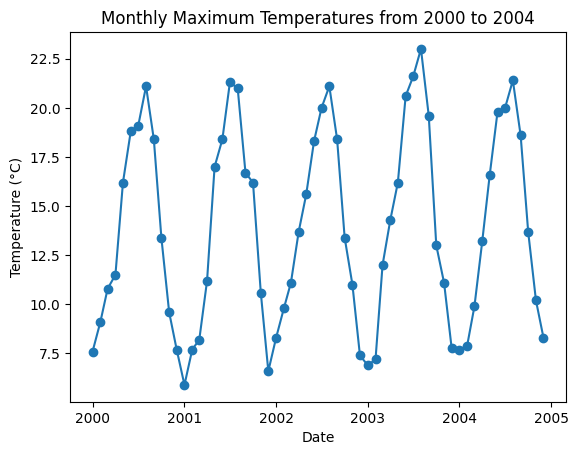

In [4]:
# Plot the data
plt.figure()
plt.plot(data_long['date'], data_long['maximum_temperature'], marker='o')
plt.title('Monthly Maximum Temperatures from 2000 to 2004')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.show()

The periodic kernel assumes that the monthly maximum temperature repeats with a known period. This is appropriate as the monthly maximum temperature appears to repeat every 12 months.

The periodic kernel assumes that the function varies smoothly within each period. This is appropriate as the monthly maximum temperature appears to vary smoothly month-to-month within each 12 month period.

The one potential issue is that there appears to be a very gradual upward trend in the monthly maximum  temperature from 2000 and 2004. The period kernel will not capture this.

### ii.

In [ ]:
# Cleared cell output in the interest of conciseness

# Data preparation
t = np.arange(1/12, 61/12, 1/12)
n = len(t)
y = data_long['maximum_temperature'].to_numpy()
p = 1
t_grid = np.linspace(0, 5, 100)  # Define a grid of points for regression function evaluation
m = len(t_grid)

# Data dictionary for Stan
sm_data = {'n': n, 't': t, 'y': y, 'p': p, 'm': m, 't_grid': t_grid}

# Build Stan object for model
sm = stan.build(gp_model, data=sm_data, random_seed=1)

# Set number of MCMC chains and iterations, then sample
chains, samples, burn = 4, 10000, 10000
fit = sm.sample(num_chains=chains, num_samples=samples, num_warmup=burn, save_warmup=False)

In [6]:
def plot_samples(fit, par, name):
    fig, axs = plt.subplots(1, 2, figsize=(10,3), constrained_layout=True)
    for i in range(2):
        axs[i].autoscale(enable=True, axis='x', tight=True)
    axs[0].set_title('Estimated marginal posterior density of ' + name)
    axs[1].set_title('Convergence of chain posterior mean estimates for ' + name)
    par_mx = fit[par].reshape(samples, chains)
    posterior_mean = np.mean(par_mx)
    print(f'Estimated posterior mean value for {par}: {posterior_mean}')
    axs[0].hist(par_mx.flatten(), 200, density=True)
    for i in range(chains):
        x = i * samples + np.arange(samples)
        axs[1].plot(x, np.cumsum(par_mx[:, i]) / range(1, samples + 1))
    plt.show()

Estimated posterior mean value for alpha: 21.290511269292345


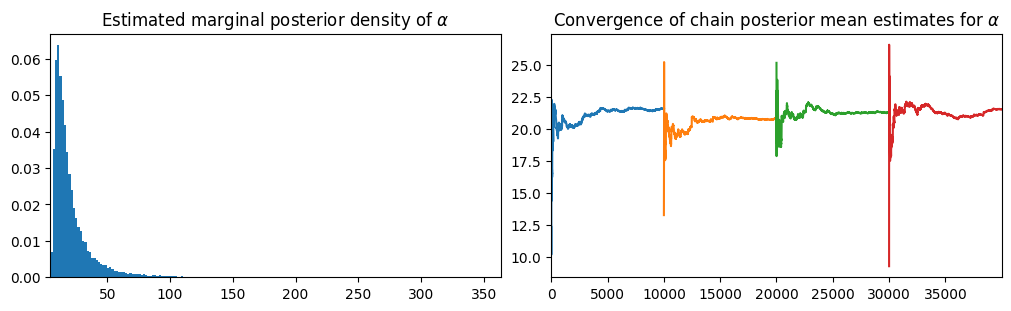

In [7]:
plot_samples(fit, 'alpha', r'$\alpha$')

Estimated posterior mean value for l: 3.565855638433606


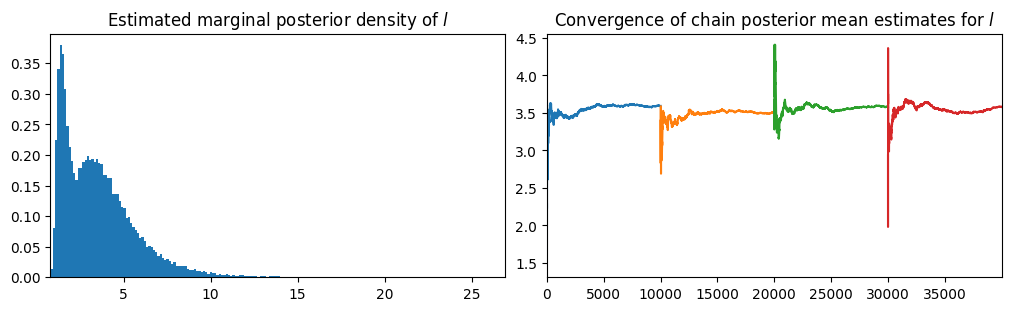

In [8]:
plot_samples(fit, 'l', r'$l$')

Estimated posterior mean value for sigma: 0.47073020057873927


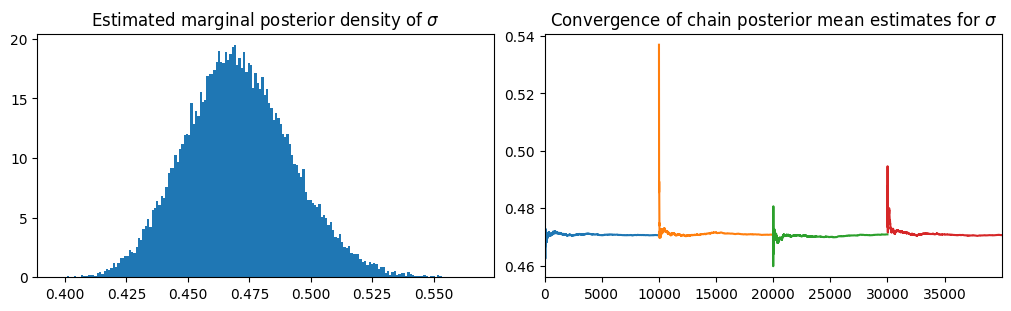

In [9]:
plot_samples(fit, 'sigma', r'$\sigma$')

### iii.

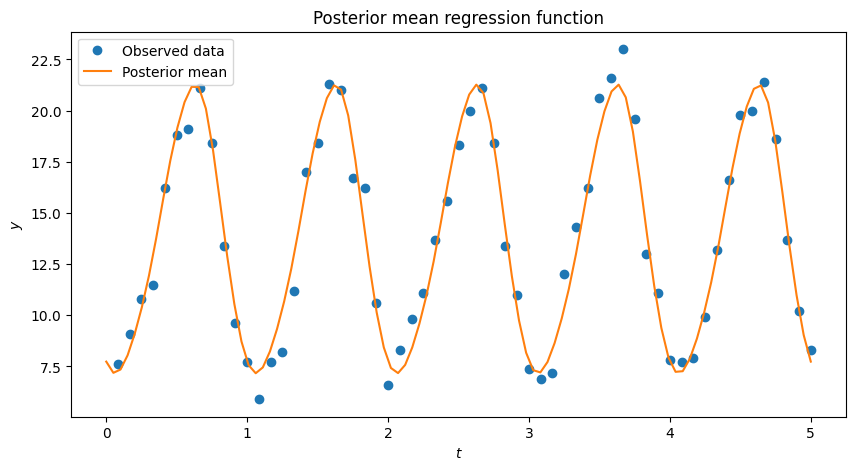

In [10]:
f = np.mean(fit['fn_vals'], axis=1)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(t, y, 'o', label='Observed data')
plt.plot(t_grid, f, label='Posterior mean')
plt.title('Posterior mean regression function')
plt.ylabel(r'$y$')
plt.xlabel(r'$t$')
plt.legend()
plt.show()

The Monte Carlo estimate of the mean regression function fits the data reasonably well. Crucially, the fit captures the periodicity of the data. However, as mentioned in my answer to part i., the very gradual upward trend in the data is not captured.

### iv.

In [11]:
samples_ppp = fit['ppp']
mean_ppp = np.mean(samples_ppp)
print(f'Posterior predictive p-value: {mean_ppp}')

Posterior predictive p-value: 0.5395


The $p$-value suggests no statistical significance, suggesting a good model fit.

# Question 2

## (a)

### i.

$$
x_{i1} = \lVert \pmb{x}_i \rVert \cos ( \theta_i )
$$

$$
x_{i2} = \lVert \pmb{x}_i \rVert \sin ( \theta_i )
$$

$$
J = \frac {\partial \pmb{x}_i} {\partial (\lVert \pmb{x}_i \rVert, \theta_i)} = \begin{pmatrix}
\frac{\partial x_{i1}}{\partial \lVert \pmb{x}_i \rVert} & \frac{\partial x_{i1}}{\partial \theta_i} \\
\frac{\partial x_{i2}}{\partial \lVert \pmb{x}_i \rVert} & \frac{\partial x_{i2}}{\partial \theta_i}
\end{pmatrix} = \begin{pmatrix}
\cos(\theta_i) & - \lVert \pmb{x}_i \rVert \sin (\theta_i) \\
\sin(\theta_i) & \lVert \pmb{x}_i \rVert \cos (\theta_i)
\end{pmatrix}
$$

$$
\det J = \begin{vmatrix}
\cos(\theta_i) & - \lVert \pmb{x}_i \rVert \sin (\theta_i) \\
\sin(\theta_i) & \lVert \pmb{x}_i \rVert \cos (\theta_i)
\end{vmatrix}
$$

$$
\implies \det J = \lVert \pmb{x}_i \rVert \cos^2 (\theta_i) + \lVert \pmb{x}_i \rVert \sin^2 (\theta_i)
$$

$$
\implies \det J = \lVert \pmb{x}_i \rVert \left\{ \cos^2 (\theta_i) + \sin^2 (\theta_i) \right\}
$$

$$
\implies \det J = \lVert \pmb{x}_i \rVert
$$

Since $\lVert \pmb{x}_i \rVert \in (0, \infty)$,

$$
\lvert \det J \rvert = \lVert \pmb{x}_i \rVert.
$$

$$
p_{\lVert \pmb{x} \rVert, \theta} (\lVert \pmb{x}_i \rVert, \theta_i) = p(\pmb{x}_i) \lvert \det J \rvert
$$

$$
\implies p_{\lVert \pmb{x} \rVert, \theta} (\lVert \pmb{x}_i \rVert, \theta_i) = \mathbb{1}_{ (0, \infty) \times [ 0, \pi / 2 ] } (\lVert \pmb{x}_i \rVert, \theta_i) \frac{2}{\pi} \exp \left( - \frac{ \lVert \pmb{x}_i \rVert ^2 } {2} \right) \lVert \pmb{x}_i \rVert
$$

$$
\implies p_{\lVert \pmb{x} \rVert, \theta} (\lVert \pmb{x}_i \rVert, \theta_i) = \mathbb{1}_{ (0, \infty) \times [ 0, \pi / 2 ] } (\lVert \pmb{x}_i \rVert, \theta_i) \frac{2}{\pi} \lVert \pmb{x}_i \rVert \exp \left( - \frac{ \lVert \pmb{x}_i \rVert ^2 } {2} \right)
$$

### ii.

**Lemma 1.**

If a random variable $X \sim \text{Rayleigh} (1)$, then $X^2 \sim \chi_2^2$.

**Proof**

Let $Y = X^2$. Then the cumulative distribution function (cdf) of $Y$ is

$$
F_Y (y) = \Pr (Y \leq y) = \Pr (X^2 \leq y) = \Pr (X \leq \sqrt{y}) = F_X (\sqrt{y}).
$$

Using the cdf of the Rayleigh distribution,

$$
F_Y (y) = 1 - \exp \left( -\frac{y}{2} \right).
$$

The probability density function (pdf) of $Y$ is therefore

$$
f_Y (y) = \frac {d F_Y (y)} {dy} = \frac{1}{2} \exp \left( -\frac{y}{2} \right).
$$

This is the pdf of a chi-squared distribution with 2 degrees of freedom. Therefore, $Y = X^2 \sim \chi_2^2$ as required.

**End of proof**

We have that

$$
p_{\lVert \pmb{x} \rVert, \theta} (\lVert \pmb{x}_i \rVert, \theta_i) = \mathbb{1}_{ (0, \infty) \times [ 0, \pi / 2 ] } (\lVert \pmb{x}_i \rVert, \theta_i) \frac{2}{\pi} \lVert \pmb{x}_i \rVert \exp \left( - \frac{ \lVert \pmb{x}_i \rVert ^2 } {2} \right).
$$

Integrate $p_{\lVert \pmb{x} \rVert, \theta} (\lVert \pmb{x}_i \rVert, \theta_i)$ over $\theta_i$ to find $p_{\lVert \pmb{x} \rVert}(\lVert \pmb{x}_i \rVert)$.

$$
p_{\lVert \pmb{x} \rVert}(\lVert \pmb{x}_i \rVert) = \int_0^{\pi / 2} p_{\lVert \pmb{x} \rVert, \theta} (\lVert \pmb{x}_i \rVert, \theta_i) d\theta_i
$$

$$
\implies p_{\lVert \pmb{x} \rVert}(\lVert \pmb{x}_i \rVert) = \int_0^{\pi / 2} \mathbb{1}_{ (0, \infty) \times [ 0, \pi / 2 ] } (\lVert \pmb{x}_i \rVert, \theta_i) \frac{2}{\pi} \lVert \pmb{x}_i \rVert \exp \left( - \frac{ \lVert \pmb{x}_i \rVert ^2 } {2} \right) d\theta_i
$$

$$
\implies p_{\lVert \pmb{x} \rVert}(\lVert \pmb{x}_i \rVert) = \mathbb{1}_{ (0, \infty) } (\lVert \pmb{x}_i \rVert) \frac{2}{\pi} \lVert \pmb{x}_i \rVert \exp \left( - \frac{ \lVert \pmb{x}_i \rVert ^2 } {2} \right) \int_0^{\pi / 2} d\theta_i
$$

$$
\implies p_{\lVert \pmb{x} \rVert}(\lVert \pmb{x}_i \rVert) = \mathbb{1}_{ (0, \infty) } (\lVert \pmb{x}_i \rVert) \frac{2}{\pi} \lVert \pmb{x}_i \rVert \exp \left( - \frac{ \lVert \pmb{x}_i \rVert ^2 } {2} \right) \left( \frac {\pi} {2} \right)
$$

$$
\implies p_{\lVert \pmb{x} \rVert}(\lVert \pmb{x}_i \rVert) = \mathbb{1}_{ (0, \infty) } (\lVert \pmb{x}_i \rVert) \lVert \pmb{x}_i \rVert \exp \left( - \frac{ \lVert \pmb{x}_i \rVert ^2 } {2} \right)
$$

This is the pdf of $\text{Rayleigh}(1)$. So we have that

$$
\lVert \pmb{x}_i \rVert \sim \text{Rayleigh}(1).
$$

Then by Lemma 1,

$$
\lVert \pmb{x}_i \rVert ^2 \sim \chi_2^2
$$

as required.

Integrate $p_{\lVert \pmb{x} \rVert, \theta} (\lVert \pmb{x}_i \rVert, \theta_i)$ over $\lVert \pmb{x}_i \rVert$ to find $p_{\theta}(\theta_i)$.

$$
p_{\theta}(\theta_i) = \int_0^{\infty} p_{\lVert \pmb{x} \rVert, \theta} (\lVert \pmb{x}_i \rVert, \theta_i) d \lVert \pmb{x}_i \rVert
$$

$$
\implies p_{\theta}(\theta_i) = \int_0^{\infty} \mathbb{1}_{ (0, \infty) \times [ 0, \pi / 2 ] } (\lVert \pmb{x}_i \rVert, \theta_i) \frac{2}{\pi} \lVert \pmb{x}_i \rVert \exp \left( - \frac{ \lVert \pmb{x}_i \rVert ^2 } {2} \right) d \lVert \pmb{x}_i \rVert
$$

$$
\implies p_{\theta}(\theta_i) = \mathbb{1}_{ [ 0, \pi / 2 ] } (\theta_i) \frac{2}{\pi} \int_0^{\infty} \lVert \pmb{x}_i \rVert \exp \left( - \frac{ \lVert \pmb{x}_i \rVert ^2 } {2} \right) d \lVert \pmb{x}_i \rVert
$$

Let $u = \lVert \pmb{x}_i \rVert ^ 2 / 2$. Then $du = \lVert \pmb{x}_i \rVert d \lVert \pmb{x}_i \rVert$ and

$$
p_{\theta}(\theta_i) = \mathbb{1}_{ [ 0, \pi / 2 ] } (\theta_i) \frac{2}{\pi} \int_0^{\infty} \exp (-u) du
$$

$$
\implies p_{\theta}(\theta_i) = \mathbb{1}_{ [ 0, \pi / 2 ] } (\theta_i) \frac{2}{\pi} \left[ - \exp (-u) \right]_0^\infty
$$

$$
\implies p_{\theta}(\theta_i) = \mathbb{1}_{ [ 0, \pi / 2 ] } (\theta_i) \frac{2}{\pi} \left[ \exp (-u) \right]_\infty^0
$$

$$
\implies p_{\theta}(\theta_i) = \mathbb{1}_{ [ 0, \pi / 2 ] } (\theta_i) \frac{2}{\pi}.
$$

This is the pdf of $\text{Uniform}(0, \pi / 2)$. So we have that

$$
\theta_i \sim \text{Uniform}(0, \pi / 2)
$$

as required.

Finally, note that

$$
p_{\lVert \pmb{x} \rVert, \theta} (\lVert \pmb{x}_i \rVert, \theta_i) = \mathbb{1}_{ (0, \infty) \times [ 0, \pi / 2 ] } (\lVert \pmb{x}_i \rVert, \theta_i) \frac{2}{\pi} \lVert \pmb{x}_i \rVert \exp \left( - \frac{ \lVert \pmb{x}_i \rVert ^2 } {2} \right)
$$

$$
\implies p_{\lVert \pmb{x} \rVert, \theta} (\lVert \pmb{x}_i \rVert, \theta_i) = \mathbb{1}_{ (0, \infty) } (\lVert \pmb{x}_i \rVert) \lVert \pmb{x}_i \rVert \exp \left( - \frac{ \lVert \pmb{x}_i \rVert ^2 } {2} \right) \mathbb{1}_{ [ 0, \pi / 2 ] } (\theta_i) \frac{2}{\pi}
$$

$$
\implies p_{\lVert \pmb{x} \rVert, \theta} (\lVert \pmb{x}_i \rVert, \theta_i) = p_{\lVert \pmb{x} \rVert}(\lVert \pmb{x}_i \rVert) p_{\theta}(\theta_i).
$$

Since the joint pdf is the product of the marginal pdfs, $\lVert \pmb{x}_i \rVert$ and $\theta_i$ are independent as required.

### iii.

**Lemma 2.**

$$
\Gamma (z + 1) = z \Gamma (z)
$$

**Proof**

The gamma function is defined for $z \in (0, \infty)$ as

$$
\Gamma (z) = \int_0^\infty t^{z-1} \exp (-t) dt.
$$

Therefore,

$$
\Gamma (z + 1) = \int_0^\infty t^{z} \exp (-t) dt.
$$

Using integration by parts,

$$
\Gamma (z + 1) = \left[ -t^{z} \exp (-t) \right]_0^\infty + \int_0^\infty z t^{z-1} \exp (-t) dt
$$

$$
\implies \Gamma (z + 1) = \lim_{t\to\infty} \left\{ -t^{z} \exp (-t) \right\} + z \Gamma (z)
$$

$$
\implies \Gamma (z + 1) = z \Gamma (z)
$$

as required.

**End of proof**

From part ii., we have that

$$
\lVert \pmb{x}_i \rVert ^2 \sim \chi_2^2.
$$

Using the first result provided and setting $k=2$,

$$
\mathbb{E} \left( \lVert \pmb{x}_i \rVert ^2 \right) = 2.
$$

Using the second result provided and setting $k=2$,

$$
\mathbb{E} \left( \lVert \pmb{x}_i \rVert \right) = \sqrt{2} \frac { \Gamma \{ (2 + 1) / 2 \} } { \Gamma (2 / 2) }
= \sqrt{2} \frac { \Gamma ( 3 / 2 ) } { \Gamma (1) }.
$$

By Lemma 2,

$$
\Gamma (3/2) = \frac {1} {2} \Gamma (1/2).
$$

By the definition of the gamma function,

$$
\Gamma (3/2) = \frac {1} {2} \int_0^\infty t^{-1/2} \exp (-t) dt.
$$

Let $t=u^2$. Then $dt = 2 u du$ and

$$
\Gamma (3/2) = \frac {1} {2} \int_0^\infty u^{-1} \exp (-u^2) 2 u du
$$

$$
\implies \Gamma (3/2) = \int_0^\infty \exp (-u^2) du.
$$

Recognising that this is closely related to the Gaussian integral,

$$
\Gamma (3/2) = \frac { \sqrt{\pi} } { 2 }.
$$

By the definition of the gamma function,

$$
\Gamma (1) = \int_0^\infty \exp (-t) dt.
$$

Therefore,

$$
\Gamma (1) = \left[ - \exp (-t) \right]_0^\infty
= \left[ \exp (-t) \right]_\infty^0
= 1.
$$

Putting it all together,

$$
\mathbb{E} \left( \lVert \pmb{x}_i \rVert \right) = \sqrt{2} \frac { \sqrt{\pi}/2 } { 1 }
= \sqrt{ \frac{\pi} {2} }.
$$

### iv.

From part ii., we have that

$$
p_{\theta}(\theta_i) = \mathbb{1}_{ [ 0, \pi / 2 ] } (\theta_i) \frac{2}{\pi}.
$$

Since $\theta_i$, $\theta_j$ are independent,

$$
p_{\theta}(\theta_i, \theta_j) = \mathbb{1}_{ [ 0, \pi / 2 ]^2 } (\theta_i, \theta_j) \frac{4}{\pi^2}.
$$

Since $\cos \theta \geq 0$ for all $\theta \in [- \pi/2, \pi/2]$,

$$
\cos \theta_{ij} = \cos \lvert \theta_i - \theta_j \rvert = \cos ( \theta_i - \theta_j ).
$$

We therefore have that

$$
\mathbb{E} (\cos \theta_{ij} ) = \int_0^{\pi/2} \int_0^{\pi/2} \cos ( \theta_i - \theta_j ) \mathbb{1}_{ [ 0, \pi / 2 ]^2 } (\theta_i, \theta_j) \frac{4}{\pi^2} d \theta_i d \theta_j
$$

$$
\implies \mathbb{E} (\cos \theta_{ij} ) = \frac{4}{\pi^2} \int_0^{\pi/2} \int_0^{\pi/2} \cos ( \theta_i - \theta_j ) d \theta_i d \theta_j.
$$

Let $u = \theta_i - \theta_j$. Then $du = d \theta_i$ and

$$
\mathbb{E} (\cos \theta_{ij} ) = \frac{4}{\pi^2} \int_0^{\pi/2} \int_{-\theta_j}^{\pi/2-\theta_j} \cos ( u ) d u d \theta_j
$$

$$
\implies \mathbb{E} (\cos \theta_{ij} ) = \frac{4}{\pi^2} \int_0^{\pi/2} \left[ \sin(u) \right]_{-\theta_j}^{\pi/2-\theta_j} d \theta_j
$$

$$
\implies \mathbb{E} (\cos \theta_{ij} ) = \frac{4}{\pi^2} \int_0^{\pi/2} \left\{ \sin(\pi/2-\theta_j) - \sin(-\theta_j) \right\} d \theta_j.
$$

Using the identities $\sin(\pi/2 - \theta) = \cos(\theta)$ and $\sin(-\theta) = -\sin(\theta)$,

$$
\mathbb{E} (\cos \theta_{ij} ) = \frac{4}{\pi^2} \int_0^{\pi/2} \left( \cos \theta_j + \sin \theta_j \right) d \theta_j
$$

$$
\implies \mathbb{E} (\cos \theta_{ij} ) = \frac{4}{\pi^2} \left[ \sin \theta_j - \cos \theta_j \right]_0^{\pi/2}
$$

$$
\implies \mathbb{E} (\cos \theta_{ij} ) = \frac{4}{\pi^2} \left\{ \left( 1 - 0 \right) - \left( 0 - 1 \right) \right\}
$$

$$
\implies \mathbb{E} (\cos \theta_{ij} ) = \frac{8}{\pi^2}.
$$

In [12]:
print(f'Expected_cos_theta_ij from analytic derivation:       {8 / np.pi**2}')

num_simulations = 1000000
theta_i = np.random.uniform(0, np.pi/2, num_simulations)
theta_j = np.random.uniform(0, np.pi/2, num_simulations)
theta_ij = np.abs(theta_i - theta_j)
expected_cos_theta_ij = np.mean(np.cos(theta_ij))
print(f'Expected_cos_theta_ij from Monte Carlo simulation:    {expected_cos_theta_ij}')

Expected_cos_theta_ij from analytic derivation:       0.8105694691387022
Expected_cos_theta_ij from Monte Carlo simulation:    0.8107951702437232


### v.

We have that

$$
a_{ij} \mid X \sim \text{Posson}(\pmb{x}_i \cdot \pmb{x}_j).
$$

From elementary properties of the Poisson distribution,

$$
\mathbb{E} (a_{ij}) = \mathbb{E} ( \pmb{x}_i \cdot \pmb{x}_j ).
$$

Using the dot product identity,

$$
\mathbb{E} (a_{ij}) = \mathbb{E} ( \lVert \pmb{x}_i \rVert \lVert \pmb{x}_j \rVert \cos \theta_{ij} ).
$$

Since $\lVert \pmb{x}_i \rVert$, $\lVert \pmb{x}_j \rVert$, $\cos \theta_{ij}$ are mutually independent,

$$
\mathbb{E} (a_{ij}) = \mathbb{E} ( \lVert \pmb{x}_i \rVert ) \mathbb{E} ( \lVert \pmb{x}_j \rVert ) \mathbb{E} ( \cos \theta_{ij} ).
$$

From part iii.,

$$
\mathbb{E} ( \lVert \pmb{x}_i \rVert ) = \mathbb{E} ( \lVert \pmb{x}_j \rVert ) = \sqrt{\frac{\pi} {2}}.
$$

From part iv.,

$$
\mathbb{E} (\cos \theta_{ij} ) = \frac{8}{\pi^2}
$$

for $i \neq j$.

Putting it all together,

$$
\mathbb{E} (a_{ij}) = \sqrt{\frac{\pi} {2}} \sqrt{\frac{\pi} {2}} \frac{8}{\pi^2}
= \frac{4}{\pi}
$$

for $i \neq j$.

### vi.

As per Section 1.5.2. of the lecture notes, the Bayesian estimator of the matrix $A$ under a Frobenius norm loss function,

$$
l (\hat{A}, A) = \lVert \hat{A} - A \rVert ^2
= \sum _ {i, j} (\hat{a}_{ij} - a_{ij}) ^2
$$

is $\mathbb{E}(A)$.

From part v., we have that

$$
\mathbb{E} (a_{ij}) = \frac{4}{\pi}.
$$

Therefore,

$$
\hat{A} = \mathbb{E}(A)
= \frac{4}{\pi} 1_{n \times n},
$$

where $1_{n \times n}$ is a $n \times n$ matrix of ones.

## (b)

### i.

As per Section 4.1 of the lecture notes,

$$
p (X \, \vert \, a_{12} = 5) \propto p (a_{12}=5 \, \vert \, X ) p(X).
$$

We have that

$$
a_{ij} \, \vert \, X \sim \text{Poisson} ( \pmb{x}_i \cdot \pmb{x}_j ).
$$

From elementary properties of the Poisson distribution,

$$
p (a_{12}=5 \, \vert \, X ) = \frac { \exp( -\pmb{x}_1 \cdot \pmb{x}_2 ) (\pmb{x}_1 \cdot \pmb{x}_2)^5 } {5!}
$$

$$
\implies p (a_{12}=5 \, \vert \, X ) \propto \exp( -\pmb{x}_1 \cdot \pmb{x}_2 ) (\pmb{x}_1 \cdot \pmb{x}_2)^5.
$$

We also have that

$$
p (\pmb{x}_i) = \mathbb{1}_{(0, \infty)^2} (\pmb{x}_i) \frac {2} {\pi} \exp \left( - \frac { \lVert \pmb{x}_i \rVert ^2 } {2} \right).
$$

Since each row is independent,

$$
p(X) = \prod _ {i=1} ^3 p (\pmb{x}_i)
$$

$$
\implies p(X) = \prod _ {i=1} ^3 \mathbb{1}_{(0, \infty)^2} (\pmb{x}_i) \frac {2} {\pi} \exp \left( - \frac { \lVert \pmb{x}_i \rVert ^2 } {2} \right)
$$

$$
\implies p(X) \propto \prod _ {i=1} ^3 \mathbb{1}_{(0, \infty)^2} (\pmb{x}_i) \exp \left( - \frac { \lVert \pmb{x}_i \rVert ^2 } {2} \right)
$$

$$
\implies p(X) \propto \mathbb{1}_{(0, \infty)^{3 \times 2}} (X) \exp \left( - \frac { \lVert \pmb{x}_1 \rVert ^2 + \lVert \pmb{x}_2 \rVert ^2 + \lVert \pmb{x}_3 \rVert ^2 } {2} \right).
$$

Putting it together,

$$
p (X \, \vert \, a_{12} = 5) \propto \exp( -\pmb{x}_1 \cdot \pmb{x}_2 ) (\pmb{x}_1 \cdot \pmb{x}_2)^5 \mathbb{1}_{(0, \infty)^{3 \times 2}} (X) \exp \left( - \frac { \lVert \pmb{x}_1 \rVert ^2 + \lVert \pmb{x}_2 \rVert ^2 + \lVert \pmb{x}_3 \rVert ^2 } {2} \right)
$$

$$
\implies p (X \, \vert \, a_{12} = 5) \propto \mathbb{1}_{(0, \infty)^{3 \times 2}} (X) (\pmb{x}_1 \cdot \pmb{x}_2)^5 \exp \left( - \pmb{x}_1 \cdot \pmb{x}_2 - \frac { \lVert \pmb{x}_1 \rVert ^2 + \lVert \pmb{x}_2 \rVert ^2 + \lVert \pmb{x}_3 \rVert ^2 } {2} \right).
$$

We can see that $\pmb{x}_1$ and $\pmb{x}_2$ are exchangeable in this posterior distribution.

### ii.

In [13]:
q2_model = """
parameters {
  array[2] real<lower=0> x1;    // first row of X
  array[2] real<lower=0> x2;    // second row of X
  array[2] real<lower=0> x3;    // third row of X
}

model {
  5 ~ poisson(dot_product(x1, x2));
  x1 ~ normal(0, 1) T[0, ];
  x2 ~ normal(0, 1) T[0, ];
  x3 ~ normal(0, 1) T[0, ];
}
"""

### iii.

In [ ]:
# Cleared cell output in the interest of conciseness

# Build Stan object for model
sm = stan.build(q2_model, random_seed=1)

# Set number of MCMC chains and iterations, then sample
chains, samples, burn = 4, 1000000, 10000
fit = sm.sample(num_chains=chains, num_samples=samples, num_warmup=burn, save_warmup=False)

In [15]:
samples_x1 = fit['x1']
samples_x2 = fit['x2']
samples_x3 = fit['x3']

samples_x1 = samples_x1.reshape(chains * samples, 2)
samples_x2 = samples_x2.reshape(chains * samples, 2)
samples_x3 = samples_x3.reshape(chains * samples, 2)

mean_x1 = np.mean(samples_x1, axis=0)
mean_x2 = np.mean(samples_x2, axis=0)
mean_x3 = np.mean(samples_x3, axis=0)

mean_X = np.array([mean_x1, mean_x2, mean_x3])
mean_A = np.dot(mean_X, mean_X.T)

print('Posterior mean of matrix A:')
print(mean_A)

Posterior mean of matrix A:
[[2.96034521 2.9602139  1.9426807 ]
 [2.9602139  2.96008328 1.94259483]
 [1.9426807  1.94259483 1.27485426]]


The elements $a_{11}$, $a_{12}$, $a_{21}$, $a_{22}$ are most influenced by the observation $a_{12} = 5$. This is because these elements involve $\pmb{x}_1$ or $\pmb{x}_2$ (which are associated with the observation) interacting with $\pmb{x}_1$ or $\pmb{x}_2$ (which are associated with the observation). The elements are updated from approximately $1.27$ to approximately $2.96$.

The elements $a_{13}$, $a_{23}$, $a_{31}$, $a_{32}$ are less influenced by the observation. This is because these elements involve $\pmb{x}_1$ or $\pmb{x}_2$ (which are associated with the observation) interacting with $\pmb{x}_3$ (which is not associated with the observation). The elements are updated from approximately $1.27$ to approximately $1.94$.

The element $a_{33}$ is not influenced by the observation. This is because this element involves $\pmb{x}_3$ (which is not associated with the observation) interacting with $\pmb{x}_3$ (which is not associated with the observation). The element remains as approximately $1.27$.